In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
aapl = pd.read_csv('AAPL_CLOSE', index_col='Date', parse_dates = True)
amzn = pd.read_csv('AMZN_CLOSE', index_col='Date', parse_dates = True)
ibm = pd.read_csv('IBM_CLOSE', index_col='Date', parse_dates = True)
cisco = pd.read_csv('CISCO_CLOSE', index_col='Date', parse_dates = True)

In [3]:
stocks = pd.concat([aapl, cisco, ibm, amzn], axis = 1)
stocks.columns = ['aapl', 'cisco', 'ibm', 'amzn']

In [4]:
stocks.head()

,aapl,cisco,ibm,amzn
Date,,,,
2012-01-03,53.063218,15.752778,160.830881,179.03
2012-01-04,53.348386,16.057180,160.174781,177.51
2012-01-05,53.940658,15.997991,159.415086,177.61
2012-01-06,54.504543,15.938801,157.584912,182.61
2012-01-09,54.418089,16.040268,156.764786,178.56


In [5]:
stocks.pct_change(1).mean()

aapl     0.000750
cisco    0.000599
ibm      0.000081
amzn     0.001328
dtype: float64

In [6]:
stocks.pct_change(1).corr()

,aapl,cisco,ibm,amzn
aapl,1.000000,0.301990,0.297498,0.235487
cisco,0.301990,1.000000,0.424672,0.284470
ibm,0.297498,0.424672,1.000000,0.258492
amzn,0.235487,0.284470,0.258492,1.000000


logarithmic return, a way to extract/normalize feature

In [7]:
stocks.pct_change(1).head()

,aapl,cisco,ibm,amzn
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005374,0.019324,-0.004079,-0.008490
2012-01-05,0.011102,-0.003686,-0.004743,0.000563
2012-01-06,0.010454,-0.003700,-0.011481,0.028152
2012-01-09,-0.001586,0.006366,-0.005204,-0.022178


In [8]:
log_ret = np.log(stocks/stocks.shift(1))
log_ret.head()

,aapl,cisco,ibm,amzn
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005360,0.019139,-0.004088,-0.008526
2012-01-05,0.011041,-0.003693,-0.004754,0.000563
2012-01-06,0.010400,-0.003707,-0.011547,0.027763
2012-01-09,-0.001587,0.006346,-0.005218,-0.022428


doesnt change much

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000291D79C30C8>,
      dtype=object)

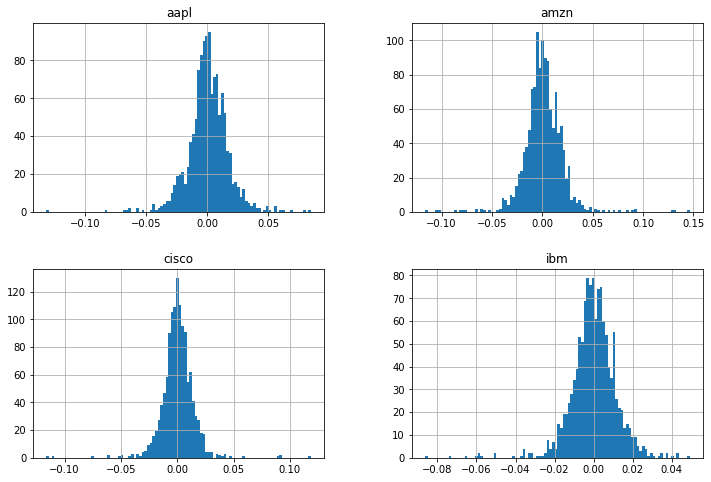

In [9]:
log_ret.hist(bins = 100, figsize=(12,8))

In [10]:
log_ret.mean()

aapl     0.000614
cisco    0.000497
ibm      0.000011
amzn     0.001139
dtype: float64

next computing pairwise covariance

In [15]:
log_ret.cov() *252

,aapl,cisco,ibm,amzn
aapl,0.068326,0.017854,0.014464,0.018986
cisco,0.017854,0.051381,0.018029,0.019956
ibm,0.014464,0.018029,0.035203,0.014939
amzn,0.018986,0.019956,0.014939,0.094470


In [16]:
print(stocks.columns)

Index(['aapl', 'cisco', 'ibm', 'amzn'], dtype='object')


In [27]:
np.random.seed(101)

num_ports = 5000
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):
    #print ('Random Weights :')
    #print(weights)
    #print('Rebalance :')
    weights = np.array(np.random.random(4))
    weights = weights / np.sum(weights)
    #print(weights)
    #expected return
    #sharpe ratio
    #print('Expected Portfolio Return')
    all_weights[ind,:] = weights
    ret_arr[ind] = np.sum((log_ret.mean()*weights)*252)
    #expected variance or volatility
    #print('expected volatility :')
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    #print(exp_vol)
    #sharpe ratio
    #print('Sharpe ratio :')
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]
    #print(SR)

In [28]:
sharpe_arr.max()

1.0303260551271067

In [29]:
sharpe_arr.argmax()

1420

In [33]:
all_weights[1420,:]

max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]


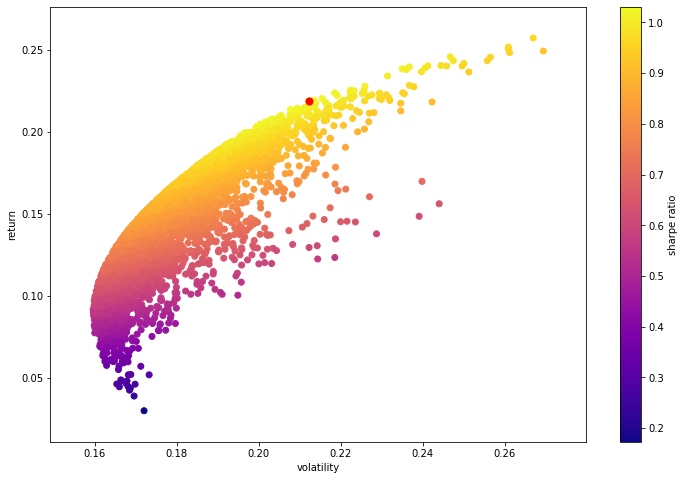

In [34]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='sharpe ratio')
plt.xlabel('volatility')
plt.ylabel('return')

plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50)

In [35]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252,weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

In [36]:
from scipy.optimize import minimize

In [37]:
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

In [38]:
def check_sum(weights):
    # return 0 if sum of the weights is 1
    return np.sum(weights) - 1

In [39]:
cons = ({'type':'eq','fun':check_sum})

In [40]:
bounds = ((0,1), (0,1), (0,1), (0,1))

In [41]:
init_guess = [0.25, 0.25, 0.25, 0.25]

In [42]:
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

In [43]:
opt_results

     fun: -1.030716870336402
     jac: array([ 5.64306974e-05,  4.18275595e-05,  3.39921728e-01, -4.44948673e-05])
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([2.66289764e-01, 2.04189819e-01, 1.75376478e-16, 5.29520418e-01])

In [44]:
opt_results.x

array([2.66289764e-01, 2.04189819e-01, 1.75376478e-16, 5.29520418e-01])

In [45]:
get_ret_vol_sr(opt_results.x)

array([0.21885916, 0.21233683, 1.03071687])

In [46]:
frontier_y = np.linspace(0, 0.3, 100)

In [47]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [48]:
frontier_volatility = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
           {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0]-possible_return})
    
    result = minimize(minimize_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_volatility.append(result['fun'])

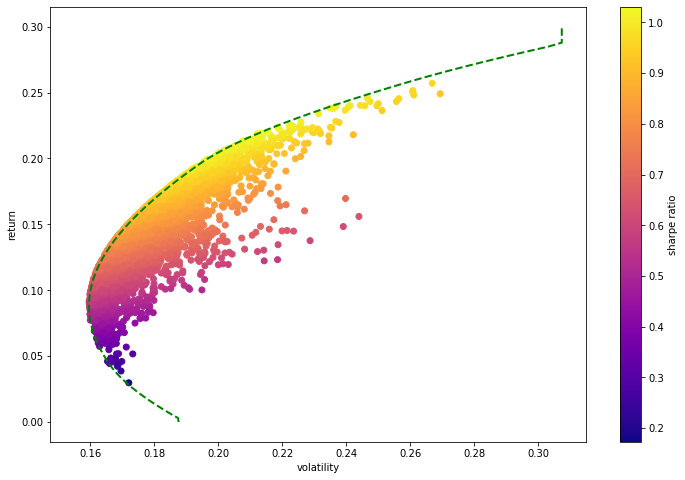

In [49]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='sharpe ratio')
plt.xlabel('volatility')
plt.ylabel('return')

plt.plot(frontier_volatility, frontier_y, 'g--', linewidth=2)